## Introduction 

This notebook is aimed to solving three questions as listed in the interview task


## Libraires and configurations

In [993]:
import pandas as pd
import matplotlib.pyplot as plt
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Data preview

In [994]:
# Read data 
billing_data = pd.read_csv('data/xyz-billing.csv')

In [995]:
# Display samples
billing_data.head()

,customerID,date,itemDescription,amount
0,customer1,31/1/2021,annual subscription,1200
1,customer1,31/1/2022,annual subscription,1200
2,customer2,31/3/2021,annual subscription,600
3,customer3,31/3/2021,annual subscription,900
4,customer3,30/11/2021,calendar purchase,50


In [996]:
# Check type and nulls
billing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customerID       62 non-null     object
 1   date             62 non-null     object
 2   itemDescription  62 non-null     object
 3   amount           62 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 2.1+ KB


In [997]:
# Check duplicate
billing_data[billing_data.duplicated()]

,customerID,date,itemDescription,amount


In [998]:
# Check distribution
billing_data.describe()

,amount
count,62.000000
mean,155.000000
std,233.625594
min,10.000000
25%,72.500000
50%,80.000000
75%,120.000000
max,1200.000000


In [999]:
# Check values of itemDescription
billing_data['itemDescription'].value_counts()

itemDescription
monthly subscription    41
calendar purchase       17
annual subscription      4
Name: count, dtype: int64

## Q1. Produce a visualization or table to show the total monthly MRR for January 2021 to June 2022 as at each month end

Assumption and solution
- Total monthly MRR includes monthly subscription and annual subscription attribution, without calendar purchase (transactions revenue).
- Annual subscription revenue should be evenly projected to the 12 months, starting in the month AFTER the billing month.
- Amount is in unit AUD 

In [1000]:
# Read data 
billing_data = pd.read_csv('data/xyz-billing.csv')

### Transfer date as datetime

In [1001]:
billing_data['datetime_date'] =  pd.to_datetime(billing_data['date'], dayfirst=True)

In [1002]:
billing_data.head()

,customerID,date,itemDescription,amount,datetime_date
0,customer1,31/1/2021,annual subscription,1200,2021-01-31
1,customer1,31/1/2022,annual subscription,1200,2022-01-31
2,customer2,31/3/2021,annual subscription,600,2021-03-31
3,customer3,31/3/2021,annual subscription,900,2021-03-31
4,customer3,30/11/2021,calendar purchase,50,2021-11-30


### Annual subscription revenue expanding

In [1003]:
# Identify annual subscriptions
annual_subscriptions = billing_data[billing_data['itemDescription'] == 'annual subscription']
display(annual_subscriptions)

,customerID,date,itemDescription,amount,datetime_date
0,customer1,31/1/2021,annual subscription,1200,2021-01-31
1,customer1,31/1/2022,annual subscription,1200,2022-01-31
2,customer2,31/3/2021,annual subscription,600,2021-03-31
3,customer3,31/3/2021,annual subscription,900,2021-03-31


In [1004]:
# Divide annual subscription amount over 12 months starting from the next month
annual_subscriptions = annual_subscriptions.copy()
# Start from the month after 
annual_subscriptions['start_date'] = annual_subscriptions['datetime_date'] + pd.DateOffset(months=1)
# End after 12 months end
annual_subscriptions['end_date'] = annual_subscriptions['start_date'] + pd.DateOffset(months = 11) +  pd.offsets.MonthEnd(0)
# Evenly attribute amount 
annual_subscriptions['amount'] = annual_subscriptions['amount'] / 12
display(annual_subscriptions)

,customerID,date,itemDescription,amount,datetime_date,start_date,end_date
0,customer1,31/1/2021,annual subscription,100.0,2021-01-31,2021-02-28,2022-01-31
1,customer1,31/1/2022,annual subscription,100.0,2022-01-31,2022-02-28,2023-01-31
2,customer2,31/3/2021,annual subscription,50.0,2021-03-31,2021-04-30,2022-03-31
3,customer3,31/3/2021,annual subscription,75.0,2021-03-31,2021-04-30,2022-03-31


In [1005]:
#Expand DataFrame to have each month as a row
expanded_annual_subscriptions = annual_subscriptions.apply(lambda row: pd.Series({
    'customerID': row['customerID'],
    'date': row['date'],
    'datetime_date': pd.date_range(row['start_date'], row['end_date'], freq='M'),
    'itemDescription': 'monthly attributed annual subscription',
    'amount': row['amount']
}), axis=1)
display(expanded_annual_subscriptions)

,customerID,date,datetime_date,itemDescription,amount
0,customer1,31/1/2021,"DatetimeIndex(['2021-02-28', '2021-03-31', '20...",monthly attributed annual subscription,100.0
1,customer1,31/1/2022,"DatetimeIndex(['2022-02-28', '2022-03-31', '20...",monthly attributed annual subscription,100.0
2,customer2,31/3/2021,"DatetimeIndex(['2021-04-30', '2021-05-31', '20...",monthly attributed annual subscription,50.0
3,customer3,31/3/2021,"DatetimeIndex(['2021-04-30', '2021-05-31', '20...",monthly attributed annual subscription,75.0


In [1006]:
# explode as new rows based on expanded datetime_date	
expanded_annual_subscriptions = expanded_annual_subscriptions.explode('datetime_date').reset_index(drop=True)
# check a sample 
display(expanded_annual_subscriptions[expanded_annual_subscriptions.customerID == 'customer2'])

,customerID,date,datetime_date,itemDescription,amount
24,customer2,31/3/2021,2021-04-30,monthly attributed annual subscription,50.0
25,customer2,31/3/2021,2021-05-31,monthly attributed annual subscription,50.0
26,customer2,31/3/2021,2021-06-30,monthly attributed annual subscription,50.0
27,customer2,31/3/2021,2021-07-31,monthly attributed annual subscription,50.0
28,customer2,31/3/2021,2021-08-31,monthly attributed annual subscription,50.0
29,customer2,31/3/2021,2021-09-30,monthly attributed annual subscription,50.0
30,customer2,31/3/2021,2021-10-31,monthly attributed annual subscription,50.0
31,customer2,31/3/2021,2021-11-30,monthly attributed annual subscription,50.0
32,customer2,31/3/2021,2021-12-31,monthly attributed annual subscription,50.0
33,customer2,31/3/2021,2022-01-31,monthly attributed annual subscription,50.0


### Concate with monthly susbcription

In [1007]:
other_subscriptions = billing_data[billing_data['itemDescription'] == 'monthly subscription']

In [1008]:
# Concatenate the prorated annual subscriptions with monthly subscriptions
all_subscriptions = pd.concat([other_subscriptions, expanded_annual_subscriptions])

In [1009]:
# set datetime_date as index 
#all_subscriptions.set_index('datetime_date', inplace=True)

# Summ MRR for each month end
mrr_per_month = all_subscriptions.groupby('datetime_date')['amount'].sum().reset_index()
# Select period 
selected_data = mrr_per_month[(mrr_per_month.datetime_date >= '2021-01-01') & (mrr_per_month.datetime_date <= '2022-06-30')]
display(selected_data)

,datetime_date,amount
0,2021-01-31,80.0
1,2021-02-28,180.0
2,2021-03-31,300.0
3,2021-04-30,425.0
4,2021-05-31,425.0
5,2021-06-30,425.0
6,2021-07-31,425.0
7,2021-08-31,425.0
8,2021-09-30,675.0
9,2021-10-31,675.0


### Plot MRR over time

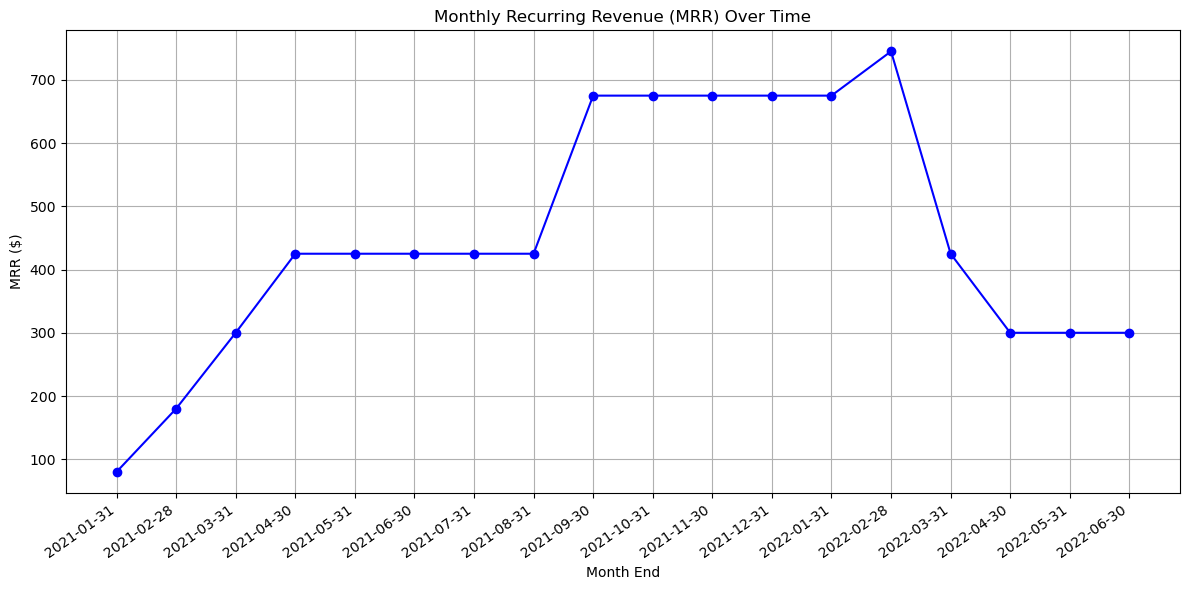

In [1015]:
# Plot the MRR over time
plt.figure(figsize=(12, 6))
plt.plot(selected_data.datetime_date.astype(str), selected_data.amount, marker='o', linestyle='-', color='b')
plt.title('Monthly Recurring Revenue (MRR) Over Time')
plt.xlabel('Month End')
plt.ylabel('MRR ($)')
plt.xticks(rotation=35, ha='right')
plt.grid(True)
plt.tight_layout()
#plt.show()

# Save the plot to a file
plt.savefig('MRR for January 2021 to June 2022 as at each month end.png')

## Q2.	Produce a visualization or table to show the monthly growth rates of MRR and calendar purchases as separate categories.

Assumption: 
 The monthly growth rate is the defined as the percentage change from the previous month.

### Calculate growth rates 

In [1019]:
# Calculate monthly growth rates for MRR 
mrr_growth = all_subscriptions.groupby('datetime_date')['amount'].sum().pct_change()
# Calculate monthly growth rates for calendar purchases
calendar_purchases = billing_data[billing_data['itemDescription'] == 'calendar purchase']
calendar_growth = calendar_purchases.groupby('datetime_date')['amount'].sum().pct_change()

### Plot monthly growth rates

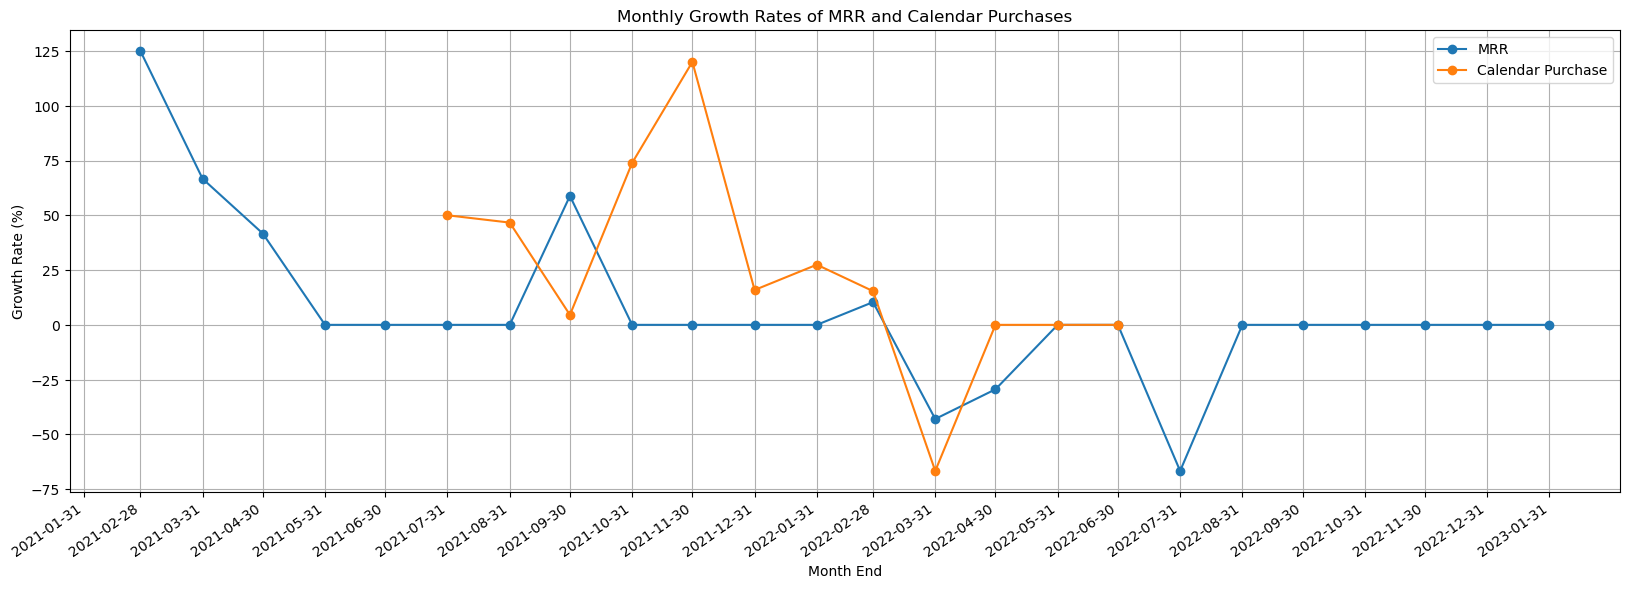

In [1020]:
plt.figure(figsize=(20, 6))
plt.plot(mrr_growth.index, mrr_growth * 100, marker='o', label='MRR')
plt.plot(calendar_growth.index, calendar_growth * 100, marker='o', label='Calendar Purchase')
plt.title('Monthly Growth Rates of MRR and Calendar Purchases')
plt.xlabel('Month End')
plt.ylabel('Growth Rate (%)')
plt.xticks(mrr_growth.index, rotation=35,  ha='right')
plt.legend()
plt.grid(True)

# Save the plot to a file 
plt.savefig('Monthly Growth Rates of MRR and Calendar Purchases.png')

## Q3. Produce a table or visualization to identify how many customers have churned each month between December 2021 and March 2022 (both months inclusive) 

To identify churn, we use the following condition:

MRR<sub>t-1</sub> > 0  and MRR<sub>t</sub> = 0 

Where:
- ( MRR<sub>t-1</sub> ) represents the Monthly Recurring Revenue in the previous month
- ( MRR<sub>t</sub> ) represents the Monthly Recurring Revenue in the current month.


### MRR per month per customer 

In [967]:
# Groupo by datetime_date and customerID
mrr_per_month = all_subscriptions.groupby(['datetime_date', 'customerID'])['amount'].sum()
# unstack customersID to be as columns 
mrr_per_month = mrr_per_month.unstack('customerID').fillna(0)
display(mrr_per_month)

customerID,Customer6,customer1,customer13,customer2,customer3,customer4,customer5
datetime_date,,,,,,,
2021-01-31,0.0,0.0,0.0,0.0,0.0,80.0,0.0
2021-02-28,0.0,100.0,0.0,0.0,0.0,80.0,0.0
2021-03-31,120.0,100.0,0.0,0.0,0.0,80.0,0.0
2021-04-30,120.0,100.0,0.0,50.0,75.0,80.0,0.0
2021-05-31,120.0,100.0,0.0,50.0,75.0,80.0,0.0
2021-06-30,120.0,100.0,0.0,50.0,75.0,80.0,0.0
2021-07-31,120.0,100.0,0.0,50.0,75.0,80.0,0.0
2021-08-31,120.0,100.0,0.0,50.0,75.0,80.0,0.0
2021-09-30,120.0,100.0,0.0,50.0,75.0,80.0,250.0


### Shift MRR per month per customer to represent previous month's MRR

In [968]:
# Shift data to previous month and fill none with 0
mrr_per_month_shifted = mrr_per_month.shift(1).fillna(0)
display(mrr_per_month_shifted)

customerID,Customer6,customer1,customer13,customer2,customer3,customer4,customer5
datetime_date,,,,,,,
2021-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-28,0.0,0.0,0.0,0.0,0.0,80.0,0.0
2021-03-31,0.0,100.0,0.0,0.0,0.0,80.0,0.0
2021-04-30,120.0,100.0,0.0,0.0,0.0,80.0,0.0
2021-05-31,120.0,100.0,0.0,50.0,75.0,80.0,0.0
2021-06-30,120.0,100.0,0.0,50.0,75.0,80.0,0.0
2021-07-31,120.0,100.0,0.0,50.0,75.0,80.0,0.0
2021-08-31,120.0,100.0,0.0,50.0,75.0,80.0,0.0
2021-09-30,120.0,100.0,0.0,50.0,75.0,80.0,0.0


### Identify churned customers and period 

In [969]:
# Get all churned customers true false per month table
churned = (mrr_per_month_shifted > 0) & (mrr_per_month == 0)
display(churned)

customerID,Customer6,customer1,customer13,customer2,customer3,customer4,customer5
datetime_date,,,,,,,
2021-01-31,False,False,False,False,False,False,False
2021-02-28,False,False,False,False,False,False,False
2021-03-31,False,False,False,False,False,False,False
2021-04-30,False,False,False,False,False,False,False
2021-05-31,False,False,False,False,False,False,False
2021-06-30,False,False,False,False,False,False,False
2021-07-31,False,False,False,False,False,False,False
2021-08-31,False,False,False,False,False,False,False
2021-09-30,False,False,False,False,False,False,False


In [970]:
# Filter the period
churned_dec_2021_to_mar_2022  = churned.loc['2021-12-31':'2022-03-31']
display(churned_dec_2021_to_mar_2022)

customerID,Customer6,customer1,customer13,customer2,customer3,customer4,customer5
datetime_date,,,,,,,
2021-12-31,False,False,False,False,False,False,False
2022-01-31,False,False,False,False,False,False,False
2022-02-28,False,False,False,False,False,False,False
2022-03-31,False,False,True,False,False,False,True


In [971]:
# Count customers per month 
true_counts_per_date = churned_dec_2021_to_mar_2022.sum(axis=1)

### Display Result 

In [972]:
# Display table result 
true_counts_df = true_counts_per_date.reset_index(name='Number of customers have churned ')
display(true_counts_df)

,datetime_date,Number of customers have churned
0,2021-12-31,0
1,2022-01-31,0
2,2022-02-28,0
3,2022-03-31,2
